In [1]:
import utils
import pandas as pd
import numpy as np
from nltk import ngrams

In [2]:
utils.PATH = 'bot_app/data/'
utils.PATH

'bot_app/data/'

In [2]:
%%time
qa_df = pd.read_json('../data/ms_marco_large.json')

# expand the answer list
answers_expanded = qa_df.answers.apply(pd.Series)

# rename each variable as answer
answers_expanded = answers_expanded.rename(columns = lambda x : 'answer_' + str(x))
answers_expanded.head()

qa_df = pd.concat([qa_df, answers_expanded], axis=1)

# remove questions without answers
qa_df = qa_df[qa_df.answer_0 != 'No Answer Present.']

# set the answer to the first element of each list
qa_df.answers = qa_df.answer_0

qa_df = qa_df.loc[:, ['answers', 'query']]

utils.save(qa_df, 'qa_df')

CPU times: user 3min 40s, sys: 9.88 s, total: 3min 50s
Wall time: 3min 48s


In [3]:
qa_df = utils.load('qa_df')
qa_df.sample(5)

,answers,query
599762,It is a member of the family Hominidae.,what is the definition of hominid
797372,Mahoning,what county is struthers ohio in?
371261,Yes,is ribavirin generic
382696,Urinary Tract Infection Test (UTI),what kind of tests i need for urinary infection
40023,Aldi and Lidl are hypermarkets in Germany.,which hypermarkets operate in germany


In [4]:
qa_df.shape

(503370, 2)

## Transform the questions into half of the feature space

In [5]:
questions = qa_df.loc[:, 'query']

In [6]:
questions[:10]

0         )what was the immediate impact of the success ...
1         _________ justice is designed to repair the ha...
10            why did stalin want control of eastern europe
100                                  why do nails get rusty
1000                                              depona ab
100000                                     nyu tuition cost
100001           at what age do kids start to hold memories
100002                          average teeth brushing time
100003                                    is funner a word?
100005                                 what is ce certified
Name: query, dtype: object

In [7]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer


In [8]:
# text transformation pipes
clean_text = Pipeline(
    [
        ('stack', FunctionTransformer(utils.stack_questions, validate=False)),
        ('clean', FunctionTransformer(utils.clean_questions, validate=False))

    ]
)

lemma_text = Pipeline(
    [
        ('lemma', FunctionTransformer(utils.apply_lemma, validate=False))
    ]
)

# feature engineering pipes
single_question_pipe = Pipeline(
    [
        ('dist', FunctionTransformer(utils.add_min_max_avg_distance_features, validate=False)),
        ('unstack', FunctionTransformer(utils.unstack_questions, validate=False))
    ]
)

pair_question_pipe = Pipeline(
    [
        ('ngram_sim', FunctionTransformer(utils.calc_ngram_similarity, kw_args={'n_grams':[1, 2, 3]}, validate=False))
    ]
)

# build features on the cleaned text only
clean_text_features = Pipeline(
    [
        ('clean', clean_text),
        ('feats', FeatureUnion(
            [
                ('pair', pair_question_pipe),
                ('single', single_question_pipe)
            ],
            n_jobs = -1
        ))
    ]
)

# build features on the cleanned and lemmatized text features
lemma_text_features = Pipeline(
    [
        ('clean', clean_text),
        ('lemma', lemma_text),
        ('feats', FeatureUnion(
            [
                ('pair', pair_question_pipe),
                ('single', single_question_pipe)
            ],
            n_jobs = -1
        ))
    ]
)

# pre-process pipe
feature_transformation = Pipeline(
    [
        ('feats', FeatureUnion(
            [
                ('clean_text_features', clean_text_features),
                ('lemma_text_features', lemma_text_features)
            ],
            n_jobs = -1
        ))
    ]
)


In [7]:
X = qa_df.rename(columns={'query':'question1'})
X['id'] = X.index
X['question2'] = 'define mentally'
X = X.drop(columns='answers')
X = X.sort_values('id').reset_index(drop=True)
X.head()

,question1,id,question2
0,)what was the immediate impact of the success ...,0,define mentally
1,_________ justice is designed to repair the ha...,1,define mentally
2,amex india customer care number,2,define mentally
3,definition of ramen,3,define mentally
4,why did rachel carson die,4,define mentally


In [9]:
%%time
X_transform = feature_transformation.transform(X)

CPU times: user 636 ms, sys: 896 ms, total: 1.53 s
Wall time: 13min 23s


In [10]:
X_transform.shape

(503370, 42)

In [11]:
X_transform[0]

array([  0.        ,   0.        ,   0.        ,   7.2979822 ,
         7.2979822 ,   7.2979822 ,   0.70618225,   0.70618225,
         0.70618225,  99.20149679,  99.20149679,  99.20149679,
         0.        ,   8.83996477,   5.64993269,   0.        ,
         0.98788862,   0.57734565,   0.        , 118.15849771,
        76.01619598,   0.        ,   0.        ,   0.        ,
         7.2979822 ,   7.2979822 ,   7.2979822 ,   0.70618225,
         0.70618225,   0.70618225,  99.20149679,  99.20149679,
        99.20149679,   5.7286128 ,   8.83996477,   7.18728101,
         0.50237131,   0.98788862,   0.73185084,  77.53224362,
       118.15849771,  96.81606282])

In [12]:
X[X.question1 == 'define mentally']

,question1,id,question2


In [104]:
X.index.get_loc(21959)

21959

In [105]:
X.iloc[X.index.get_loc(21959)]

question1    define mentally
id                     33865
question2    define mentally
Name: 21959, dtype: object

In [112]:
print(X_transform[21959].shape)
X_transform[21959]

(42,)


array([ 1.        ,  1.        ,  1.        ,  7.2979822 ,  7.2979822 ,
        7.2979822 ,  0.70618225,  0.70618225,  0.70618225, 99.20149679,
       99.20149679, 99.20149679,  7.2979822 ,  7.2979822 ,  7.2979822 ,
        0.70618225,  0.70618225,  0.70618225, 99.20149679, 99.20149679,
       99.20149679,  1.        ,  1.        ,  1.        ,  7.2979822 ,
        7.2979822 ,  7.2979822 ,  0.70618225,  0.70618225,  0.70618225,
       99.20149679, 99.20149679, 99.20149679,  7.2979822 ,  7.2979822 ,
        7.2979822 ,  0.70618225,  0.70618225,  0.70618225, 99.20149679,
       99.20149679, 99.20149679])

In [113]:
xgb.predict_proba(X_transform[21959].reshape(1, -1))[:, 1]

array([0.4627599], dtype=float32)

In [14]:
xgb = utils.load('xgb_FINAL_model_question_swapped')
y_probs = xgb.predict_proba(X_transform)[:,1]

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [15]:
X_ind = X.reset_index()
merge_questions = pd.concat([X_ind, pd.Series(y_probs)], axis=1, sort=False, ignore_index=True)
merge_questions = merge_questions.rename(columns={1:'question1', 3:'question2', 4:'prob'})
merge_questions.sort_values('prob', ascending=False)

,0,question1,2,question2,prob
398244,398244,define messrs,650445,define mentally,9.640142e-01
70926,70926,define pissant,112178,define mentally,9.627835e-01
483662,483662,define corny,774740,define mentally,9.529935e-01
340311,340311,define scathe,555735,define mentally,9.495116e-01
485911,485911,define mote,778867,define mentally,9.494941e-01
429167,429167,define coss,705392,define mentally,9.468670e-01
39983,39983,define logorrhea,60879,define mentally,9.454870e-01
374262,374262,define callow,611096,define mentally,9.439466e-01
415147,415147,define ff,679502,define mentally,9.431165e-01
29553,29553,define jibes,43686,define mentally,9.403343e-01


## App data

All data below needs to be pre-calculated

In [7]:
%%time
cleaned_questions = utils.clean_questions(questions)
lemma_questions = utils.apply_lemma(cleaned_questions)

utils.save(cleaned_questions, 'cleaned_questions')
utils.save(lemma_questions, 'lemma_questions')

CPU times: user 3min 55s, sys: 1min 5s, total: 5min
Wall time: 3min 39s


In [8]:
def tokenize_questions(X):
    texts = []
    for doc in utils.nlp.pipe(X, disable=['parser', 'ner'], batch_size=10000):
        texts.append(doc.to_array([utils.spacy.attrs.LOWER]))
    return texts

In [9]:
%%time
clean_tokens = tokenize_questions(cleaned_questions)
lemma_tokens = tokenize_questions(lemma_questions)

utils.save(clean_tokens, 'clean_tokens')
utils.save(lemma_tokens, 'lemma_tokens')

CPU times: user 7min 20s, sys: 1min 49s, total: 9min 10s
Wall time: 6min 46s


In [15]:
# build features on the cleaned text only
clean_text_features = Pipeline(
    [
        ('clean', FunctionTransformer(utils.clean_questions, validate=False)),
        ('dist', FunctionTransformer(utils.add_min_max_avg_distance_features, validate=False))
    ]
)

# build features on the cleanned and lemmatized text features
lemma_text_features = Pipeline(
    [
        ('clean', FunctionTransformer(utils.clean_questions, validate=False)),
        ('lemma', lemma_text),
        ('dist', FunctionTransformer(utils.add_min_max_avg_distance_features, validate=False))
    ]
)


In [19]:
%%time
clean_question_features = clean_text_features.transform(questions)
lemma_question_features = lemma_text_features.transform(questions)

utils.save(clean_question_features, 'clean_question_features')
utils.save(lemma_question_features, 'lemma_question_features')

CPU times: user 17min 31s, sys: 3min 15s, total: 20min 46s
Wall time: 14min 16s


In [68]:
xgb = utils.load('xgb_FINAL_model')

In [45]:
def ngram_similarity(q_token, token_db,  n_grams=[1, 2, 3]):
    ''' Calculates the ngram similarity between a pair of questions. Similarity is defined as,
            2 · ( |S1| / |S1 ∩ S2| + |S2| / |S1 ∩ S2|)^−1
        where S_i is the ngrams for question i
        
        n_grams: list
        List of n-grams to calculate, i.e. [1, 2, 3]
        
        return: array-like (n_pairs, len(n_grams))
        N-dimensional array of n_gram similarity calculated for the different n_grams.
        
    '''
    ngram_sim = []
    ngram_q2 = [set(ngrams(q_token, i, pad_right=True)) for i in n_grams]
    for t in token_db:
        ngram_q1 = [set(ngrams(t, i, pad_right=True)) for i in n_grams]

        doc_ngram_sim = []
        for i in range(len(ngram_q1)):
            try:
                s1 = len(ngram_q1[i]) / len(ngram_q1[i].intersection(ngram_q2[i]))
            except:
                s1 = 0

            try:
                s2 = len(ngram_q2[i]) / len(ngram_q1[i].intersection(ngram_q2[i]))
            except:
                s2 = 0

            if s1 == 0 and s2 == 0:
                doc_ngram_sim.append(0)
            else:
                doc_ngram_sim.append(2 * (s1 + s2)**-1)
        ngram_sim.append(doc_ngram_sim)
        
    return np.array(ngram_sim)


In [83]:
def ask_question(question):
    
    question_clean = utils.clean_questions([question]) ## returns an array
    ## if question is a duplicate after cleaning, then return the answer
    if question_clean[0] in cleaned_questions:
        return question_clean
    
    ## else run the model
    else:    
        ## Feature Set 1 -- clean text similarity
        ## create the tokens for the question
        doc = utils.nlp(question_clean[0])
        question_tokens = doc.to_array([utils.spacy.attrs.LOWER])
        clean_n_gram = ngram_similarity(question_tokens, clean_tokens)

        ## Feature Set 2 -- Clean distance features
        # union single question features
        question_features = clean_text_features.transform([question]) 
        clean_single_features = np.hstack([clean_question_features, 
                                           np.repeat(question_features, clean_question_features.shape[0], axis=0)])
        

        ## Feature Set 3 -- Lemma text similarity
        # calculate n_gram similarity for the cleaned and lemmatized question
        question_lemma = utils.apply_lemma(question_clean)
        doc = utils.nlp(question_lemma[0])
        question_tokens = doc.to_array([utils.spacy.attrs.LOWER])
        lemma_n_gram = ngram_similarity(question_tokens, lemma_tokens)


        ## Feature Set 4 -- Lemma distance features
        # union single question features
        question_features = lemma_text_features.transform([question]) 
        lemma_single_features = np.hstack([lemma_question_features, 
                                           np.repeat(question_features, lemma_question_features.shape[0], axis=0)])

    ### Transform through the whole pipeline
#     df_cleaned_questions['question2'] = question
    
#     feature_space = feature_pipe.transform(df_cleaned_questions[:5000])

        # make the prediction
        feature_space = np.hstack([clean_n_gram, clean_single_features, lemma_n_gram, lemma_single_features])
        probs = xgb.predict_proba(feature_space)[:, 1]

        top = probs.argsort()[-3:]
        top_question = np.array(qa_df.iloc[top]).reshape(len(top), -1)
        top_probs = probs[top].reshape(-1, 1)

#     return None
#     return pd.DataFrame(np.hstack([top_question, top_probs]))
        return feature_space, pd.DataFrame(np.hstack([top_question, top_probs]))

In [74]:
ask_question('do owls eat in the day')

['do owls eat in the day']

In [64]:
ask_question('do owls eat at night')

(101093, 42)

In [84]:
features, top_results = ask_question('what causes earthquakes')

In [19]:
'do owls eat in the day' in cleaned_questions

True

In [250]:
df[df.question1 == 'do owls eat in the day']

,question1,id,question2
4,do owls eat in the day,4,do owls eat in the day


In [85]:
top_results # full pipeline

,0,1,2,3,4,5,6
0,[No Answer Present.],"[{'is_selected': 0, 'passage_text': 'What is a...",what causes boil water notice,586008,DESCRIPTION,[],0.861625
1,[Humans can cause earthquakes by triggering se...,"[{'is_selected': 0, 'passage_text': 'An uptick...",how can humans cause earthquakes,210161,DESCRIPTION,[],0.863643
2,[Stasis dermatitis cause extremely sensitive a...,"[{'is_selected': 0, 'passage_text': 'Poor circ...",stasis dermatitis causes,1090422,DESCRIPTION,[],0.895012


In [72]:
top_results # opt pipeline

,0,1
0,what causes fingers to swell at night,0.2007
1,what causes swelling in hands at night,0.30395
2,do owls eat in the day,0.408373


In [251]:
features[4]

array([  1.        ,   1.        ,   1.        ,   4.63359628,
         8.4752183 ,   6.82304781,   0.44451424,   0.94712703,
         0.66871357,  62.24226321, 115.15204134,  92.26256858,
         4.63359628,   8.4752183 ,   6.82304781,   0.44451424,
         0.94712703,   0.66871357,  62.24226321, 115.15204134,
        92.26256858,   1.        ,   1.        ,   1.        ,
         6.72955502,   8.34001638,   7.60125726,   0.55986509,
         0.79268708,   0.69988742,  92.72933482, 111.52220958,
       102.69947146,   6.72955502,   8.34001638,   7.60125726,
         0.55986509,   0.79268708,   0.69988742,  92.72933482,
       111.52220958, 102.69947146])

In [214]:
probs = xgb.predict_proba(features)[:, 1]

In [218]:
xgb.predict_proba(features[20546].reshape(1, -1))[:, 1]

array([0.1619365], dtype=float32)

In [216]:
probs[20546]

0.1619365

In [220]:
import matplotlib.pyplot as plt
print(xgb.feature_importances_)

[0.02938479 0.02320101 0.01954768 0.01709631 0.0290843  0.02475091
 0.02119247 0.03724498 0.03382888 0.01341136 0.02718646 0.02229954
 0.01790289 0.02774    0.02487743 0.0211134  0.03670726 0.03213665
 0.0142812  0.02740788 0.02233117 0.02340661 0.01603669 0.01205124
 0.02133481 0.02304286 0.02117666 0.02979598 0.03019137 0.02762929
 0.01991143 0.02397596 0.02027519 0.0207022  0.02217302 0.0199747
 0.02709157 0.03117191 0.02400759 0.01902578 0.02492488 0.01937371]


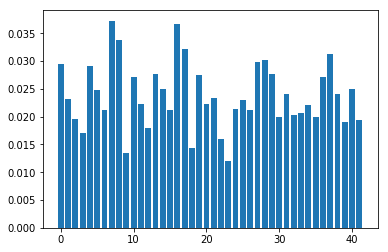

In [221]:
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

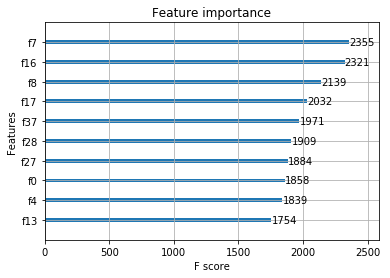

In [240]:
from xgboost import plot_importance
plot_importance(xgb, max_num_features=10)
plt.show()

In [236]:
feature_names = [
    'clean_1_gram_sim',
    'clean_2_gram_sim',
    'clean_3_gram_sim',
    'clean_euc_min_q1',
    'clean_euc_max_q1',
    'clean_euc_avg_q1',
    'clean_cos_min_q1',
    'clean_cos_max_q1',
    'clean_cos_avg_q1',
    'clean_man_min_q1',
    'clean_man_max_q1',
    'clean_man_avg_q1',
    'clean_euc_min_q2',
    'clean_euc_max_q2',
    'clean_euc_avg_q2',
    'clean_cos_min_q2',
    'clean_cos_max_q2',
    'clean_cos_avg_q2',
    'clean_man_min_q2',
    'clean_man_max_q2',
    'clean_man_avg_q2',
    'lemma_1_gram_sim',
    'lemma_2_gram_sim',
    'lemma_3_gram_sim',
    'lemma_euc_min_q1',
    'lemma_euc_max_q1',
    'lemma_euc_avg_q1',
    'lemma_cos_min_q1',
    'lemma_cos_max_q1',
    'lemma_cos_avg_q1',
    'lemma_man_min_q1',
    'lemma_man_max_q1',
    'lemma_man_avg_q1',
    'lemma_euc_min_q2',
    'lemma_euc_max_q2',
    'lemma_euc_avg_q2',
    'lemma_cos_min_q2',
    'lemma_cos_max_q2',
    'lemma_cos_avg_q2',
    'lemma_man_min_q2',
    'lemma_man_max_q2',
    'lemma_man_avg_q1'
    
]
print(len(feature_names))

42


In [253]:
def print_features(l=[7, 16, 8, 17, 37, 28, 27, 0, 4, 13]):
    for n in l:
#         print(n)
        print(feature_names[n])
print_features()

clean_cos_max_q1
clean_cos_max_q2
clean_cos_avg_q1
clean_cos_avg_q2
lemma_cos_max_q2
lemma_cos_max_q1
lemma_cos_min_q1
clean_1_gram_sim
clean_euc_max_q1
clean_euc_max_q2


In [238]:
features[20456, [7, 16, 8, 17, 37]]

array([0.96252071, 1.08482914, 0.72458074, 0.68943047, 1.06595845])

In [239]:
xgb.get_booster().get_fscore()

{'f1': 1467,
 'f21': 1480,
 'f0': 1858,
 'f28': 1909,
 'f7': 2355,
 'f29': 1747,
 'f6': 1340,
 'f8': 2139,
 'f12': 1132,
 'f4': 1839,
 'f16': 2321,
 'f2': 1236,
 'f27': 1884,
 'f17': 2032,
 'f39': 1203,
 'f22': 1014,
 'f13': 1754,
 'f18': 903,
 'f10': 1719,
 'f37': 1971,
 'f19': 1733,
 'f23': 762,
 'f38': 1518,
 'f34': 1402,
 'f5': 1565,
 'f24': 1349,
 'f3': 1081,
 'f25': 1457,
 'f32': 1282,
 'f41': 1225,
 'f15': 1335,
 'f35': 1263,
 'f20': 1412,
 'f26': 1339,
 'f31': 1516,
 'f33': 1309,
 'f9': 848,
 'f36': 1713,
 'f30': 1259,
 'f40': 1576,
 'f11': 1410,
 'f14': 1573}

In [ ]:
#### ask_question('What is the capital of Washington?')
# ask_question('noncontagious definition')
ask_question('where is the stamen located in a flower')

In [188]:
qa_df.loc[:, 'query'].sample()

27505    where is the stamen located in a flower
Name: query, dtype: object

In [167]:
p.argsort()[-3:]

array([21032, 80760, 14203])

In [166]:
questions.iloc[p.argsort()[-3:]]
# questions.iloc[1]

27943     which is the original delmonico's
81699               what state is borths in
21797    what is the meaning of the bowery?
Name: query, dtype: object

In [168]:
q_array = np.array(questions)

In [169]:
q_array[14203]

'what is the meaning of the bowery?'

In [170]:
q_array[80760]

'what state is borths in'

In [72]:
q = ['What is the capital of Washington?']

In [76]:
np.repeat(q, 2, axis=0).shape

(2,)

In [108]:
utils.save(token_text, 'questions_tokenized')


In [104]:
for t in token_text:
    print(type(t))
    break

<class 'numpy.ndarray'>


In [97]:
from nltk import ngrams

In [107]:
for n in ngrams(np.array(token_text[0]), 3, pad_right=True):
    print(n)

(8532415787641010193, 5865838185239622912, 3411606890003347522)
(5865838185239622912, 3411606890003347522, 11901859001352538922)
(3411606890003347522, 11901859001352538922, 14070511896034874754)
(11901859001352538922, 14070511896034874754, None)
(14070511896034874754, None, None)


In [111]:
doc = utils.nlp('What is the capital of Washington?')
q_tokens = doc.to_array([utils.spacy.attrs.LOWER])

In [116]:
np.hstack([np.array(token_text).reshape(-1, 1), np.repeat(q_tokens, len(token_text), axis=0).reshape(1, -1)]).shape

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [117]:
t = np.array(token_text).reshape(-1, 1)

In [118]:
t.shape

(101093, 1)

In [119]:
t

array([[array([ 8532415787641010193,  5865838185239622912,  3411606890003347522,
       11901859001352538922, 14070511896034874754], dtype=uint64)],
       [array([16315412628806490806, 13583488448875926965, 11779693057662023107,
        2619154345045139155, 15597474948775060119, 15099054000809333061,
        1920611397140219205,  3791531372978436496, 13569477888548814854],
      dtype=uint64)],
       [array([16315412628806490806, 13583488448875926965,  7425985699627899538,
       11900862162089982680,  6184037061712818460,  3142894986720291236,
        3791531372978436496, 17339002579355368042,  9095968958430269659,
       10313580197444822952,  9952569212994313472], dtype=uint64)],
       ...,
       [array([16331095434822636218, 12965068231793614765,  3791531372978436496,
        7340758616018961957, 10606469382566443026, 16929211676819693673],
      dtype=uint64)],
       [array([ 3077651023035088716,  6878210874361030284,  3791531372978436496,
       13320680580156776400, 1412212

In [127]:
v = np.repeat(q_tokens, len(token_text))

In [128]:
v.shape

(707651,)

In [124]:
len(token_text)

101093

In [133]:
%%time
ngram_similarity(q_tokens)

CPU times: user 3.62 s, sys: 69 ms, total: 3.69 s
Wall time: 4.64 s


array([[0.33333333, 0.16666667, 0.        ],
       [0.        , 0.        , 0.        ],
       [0.11111111, 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])